In [10]:
import numpy as np

from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.feature import match_descriptors
from skimage.exposure import rescale_intensity
from skimage.util import img_as_float, img_as_ubyte
from skimage import transform
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb


from skimage.draw import (line, circle_perimeter)
from enum import Enum

%matplotlib notebook 


### DAISY implementation

implementation of DAISY descriptors calculation for the whole image

In [11]:
class NormType(Enum):
    NRM_NONE = 1
    NRM_PARTIAL = 2 
    NRM_FULL = 3
    NRM_SIFT_STYLE = 4

# Computes a Gradient Orientation Map on derivative axis
# with angle tetha
def gradient_orientation(image, tetha):
    # Steering filter - combination of X and Y derivatives 
    # to det a derivative on a specific angle
    d_hor = sobel_h(image)
    d_ver = sobel_v(image)
    derivative = d_hor * np.cos(tetha) + d_ver * np.sin(tetha)
    # Operator max(d, 0) levaes only positive derivative
    derivative = derivative.clip(min=0)
    return derivative

# Compute GOs for a number of directions
def compute_global_orientation_maps(image, H):
    tetha_step = 2 * np.pi / H
    result = []
    for k in range(0, H):
        tetha = tetha_step * k
        result.append(gradient_orientation(image, tetha))
    return result

# Convolves orientation maps with Gaussian
# kernels with specified standard deviations
def convolve_orientation_maps(gos, sigmas):
    result = []
    for sigma in sigmas:
        conv = []
        for go in gos:
            conv.append(gaussian(go, sigma))
        result.append(conv)
    return result

def daisy_full(image, R, Q, T, H, sigmas, norm=NormType.NRM_NONE):
     # Setting steps in angle and radius
    tetha_step = 2 * np.pi / T
    radius_step = float(R) / Q
    # Calculating total number of entries in a descriptor
    Ds = (Q*T+1)*H
    
    # Copy of image for visualization
    visualize = np.copy(image)
    
    # Compute GOs
    gradient_orientations = compute_global_orientation_maps(image, H)
    # Convolve GOs with Gaussian kernels to get COMs
    conv_orient_maps = convolve_orientation_maps(gradient_orientations, sigmas)
    
    img_shape = image.shape
    rows = img_shape[0] // (2 * R)
    columns = img_shape[1] // (2 * R)
    
    descriptors = []
    
    for desc_i in range(1, rows):
        for desc_j in range(1, columns):
            descriptor = np.zeros((1, Ds))
            # Sampling vectors from COMs at DAISY points
            # Center point
            center = [R  * desc_i * 2, R * desc_j * 2]
            h = sample_h_vector(center[0], center[1], conv_orient_maps[0], visualize, sigmas[0])
            descriptor[0, 0:H] = h
            # Sample the rest of the points in DAISY pattern
            for i in range(0, Q):
                r = (i+1) * radius_step
                maps = conv_orient_maps[i]
                for j in range(0, T):
                    tetha = j * tetha_step
                    x = int(center[0] + r * np.cos(tetha))
                    y = int(center[1] + r * np.sin(tetha))

                    h = sample_h_vector(x, y, maps, visualize, sigmas[i+1])
                    # Normalization for partial norm type
                    if norm == NormType.NRM_PARTIAL:
                        h = preprocessing.normalize(h.reshape((1, -1)), norm='l2')

                    idx_start = ((i)*T+j)*H+H
                    idx_end = ((i)*T+j)*H+2*H
                    descriptor[0, idx_start:idx_end] = h

            # Normalization for full norm type
            if norm == NormType.NRM_FULL:
                descriptor = preprocessing.normalize(descriptor.reshape((1, -1)), norm='l2')
            # Normalization for SIFT-style norm
            if norm == NormType.NRM_SIFT_STYLE:
                descriptor = preprocessing.normalize(descriptor.reshape((1, -1)), norm='l2')
                descriptor = descriptor.clip(max=0.154)
                descriptor /= descriptor.sum()
                
            descriptors.append(descriptor)
    
    result = np.array(descriptors)
        
    return result, visualize, gradient_orientations, conv_orient_maps


# Samples the single h vector at point 
def sample_h_vector(x, y, maps, visualize, sigma):
    # Sampling the vector
    h = np.zeros(H)
    for k in range(0, H):
        h[k] = maps[k][x, y]
    # Visualize the point
    draw_circle(visualize, x, y, sigma)
    draw_lines(visualize, x, y, sigma, H)
    return h

#### Utility functions
Functions for data visualization

In [12]:
# Draws a circle
def draw_circle(image, x, y, radius):
    rr, cc = circle_perimeter(x, y, radius)
    if x+radius >= image.shape[0] or y+radius >= image.shape[1]:
        return
    image[rr, cc] = 1

# Draws a set of evenly arranged lines from center
def draw_lines(image, x, y, radius, n):
    tetha_step = 2 * np.pi / n
    for i in range(0, n):
        tetha = i * tetha_step
        line_len = int(radius * 0.7)
        x1 = int(x + line_len * np.sin(tetha))
        j1 = int(y + line_len * np.cos(tetha))
        rr, cc = line(x, y, x1, j1)
        if x1 >= image.shape[0] or j1 >= image.shape[1]:
            continue
        image[rr, cc] = 1
    
# Shows an image
def imgshow(image, title='', cmap=plt.cm.gray):
    fig, ax = plt.subplots()
    ax.imshow(img_as_ubyte(image), cmap=cmap)
    ax.set_title(title)
    plt.show()

# Shows a set of images in a grid 
def show_maps(maps, title=''):
    grid_i = 2
    grid_j = int(np.ceil(len(maps) / 2))
    fig, ax = plt.subplots(grid_i, grid_j)
    fig.suptitle(title)
    for i in range(0, grid_i):
        for j in range(0, grid_j):
            idx = i*grid_j+j
            if(idx >= len(maps)):
                break
            ax[i, j].set_title(idx)
            ax[i, j].imshow(maps[idx], cmap = plt.cm.plasma)
    plt.tight_layout()

# Simple XY 2d plot
def plot_xy(x, y, title='', xlabel='', ylabel=''):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.grid()
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

## Test data preparation
We use a 128 * 128 sample of a contrast grayscale image from skimage.data

(500, 741)


<IPython.core.display.Javascript object>


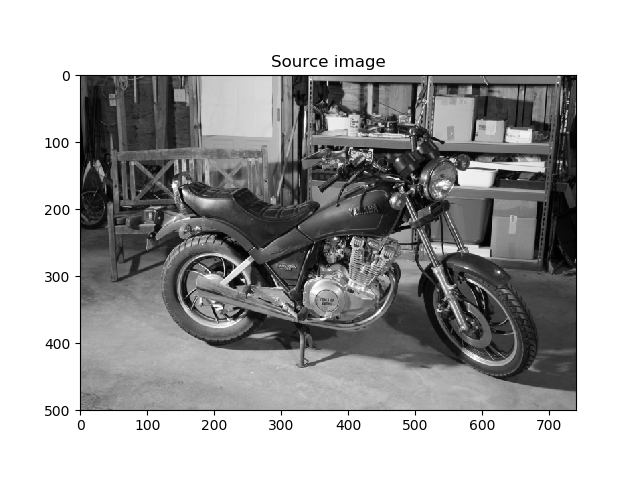

Image size:(500, 741)


In [13]:
img_left, img_right, disp = data.stereo_motorcycle()

img_src = rgb2gray(img_as_float(img_left))

print(img_src.shape)

image = img_src
imgshow(image, 'Source image')
print(f'Image size:{image.shape}')

## Testing section 
Here is the list of modifiable parameters:
* Maximum radius $R$
* Number of rings $Q$
* Number of points per ring $T$
* Number of histograms per point $H$
* Gaussian filter standard deviations $\sigma$ for each ring
* Normalization type

**Notice that big sigma values or radius may result in index out of bounds exception!** 

In [14]:
R = 30
Q = 2
T = 6
H = 8
SIGMAS = [5, 10, 25]
NORM = NormType.NRM_SIFT_STYLE

Took 3223.999 ms


<IPython.core.display.Javascript object>


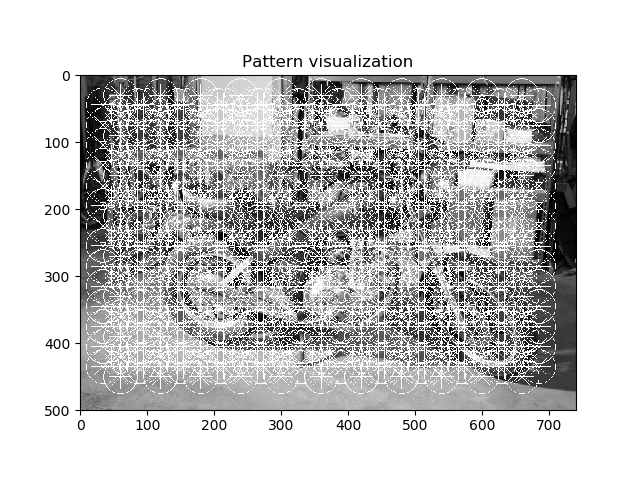

C:\Users\Jane Doe\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


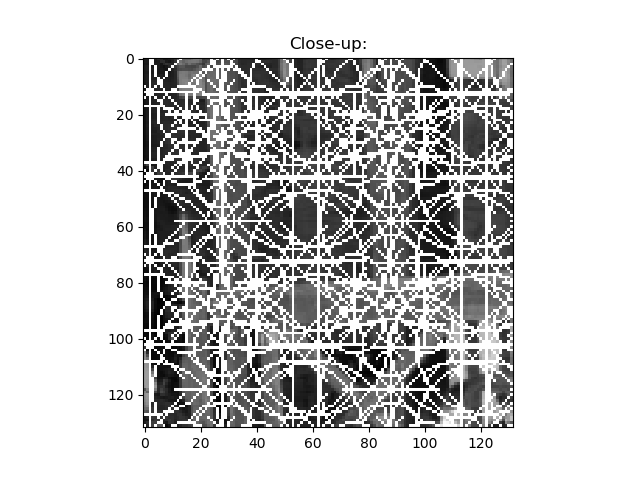

In [15]:
# Computing one descriptor at the center of the image
x, y = image.shape
point = [int(x/2), int(y/2)]

import time
time1 = time.time()

descriptors, visualize, gradient_orientations, coms = daisy_full(image, R, Q, T, H, SIGMAS, NORM)

time2 = time.time()
print('Took {:.3f} ms'.format((time2-time1)*1000.0))


imgshow(visualize, title='Pattern visualization')

part = visualize[32:164, 32:164]
imgshow(part, title='Close-up:')

In [16]:
print(f'Results shape: {descriptors.shape}')
print(f'Single descriptor shape:\n {descriptors[0].shape}\n')
print(f'Single descriptor:\n {descriptors[0]}\n')
print(f'Descriptor norm: {np.linalg.norm(descriptors[0])}')
print(f'Sum:{np.sum(descriptors[0])}')

Results shape: (77, 1, 104)
Single descriptor shape:
 (1, 104)

Single descriptor:
 [[0.00273817 0.01315129 0.01715979 0.01531712 0.00407314 0.01419661
  0.01715979 0.01447451 0.00375679 0.01569022 0.01715979 0.01715979
  0.00495935 0.01266778 0.01715979 0.01325313 0.00724256 0.00450238
  0.00218893 0.00315323 0.00457862 0.00901201 0.01123045 0.01143024
  0.00482866 0.00384051 0.00382658 0.00454053 0.00506419 0.00986872
  0.01211622 0.01023564 0.0048071  0.00724932 0.00974763 0.00951843
  0.00596861 0.01580851 0.01715979 0.01643501 0.00444591 0.00996207
  0.01451799 0.01715979 0.01393738 0.00965086 0.0045864  0.00522394
  0.00699046 0.00985555 0.01017609 0.01033389 0.00711645 0.00592839
  0.00449626 0.00622854 0.00471659 0.01351514 0.01715979 0.01462342
  0.00416372 0.0118479  0.01674489 0.01373806 0.00661411 0.00674226
  0.00667678 0.00716366 0.00677847 0.00632861 0.00592743 0.00651756
  0.00501556 0.0086749  0.01124444 0.01052421 0.00628421 0.00961532
  0.01130574 0.00967048 0.011390

<IPython.core.display.Javascript object>


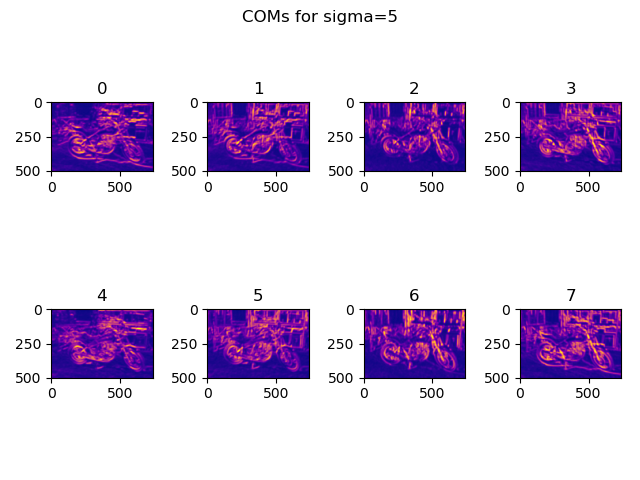

<IPython.core.display.Javascript object>


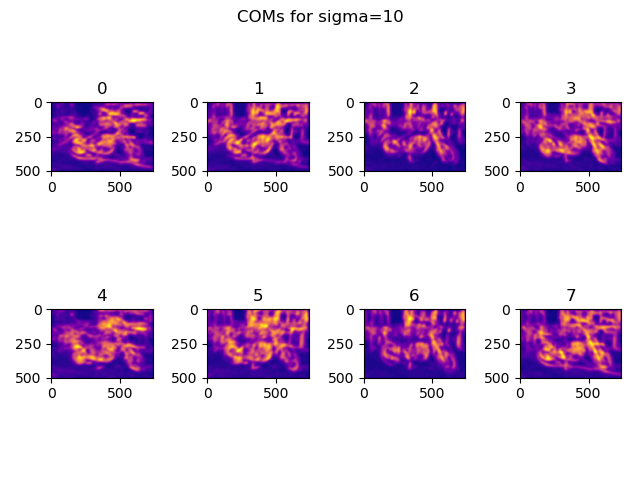

<IPython.core.display.Javascript object>


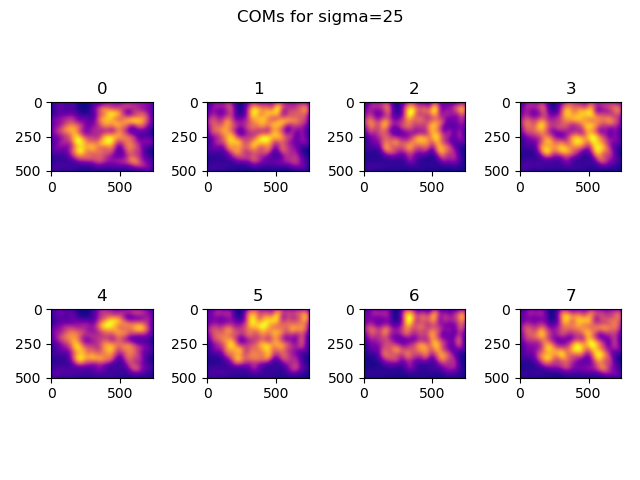

In [17]:
for i in range(len(SIGMAS)):
    show_maps(coms[i], title=f'COMs for sigma={SIGMAS[i]}')

<IPython.core.display.Javascript object>


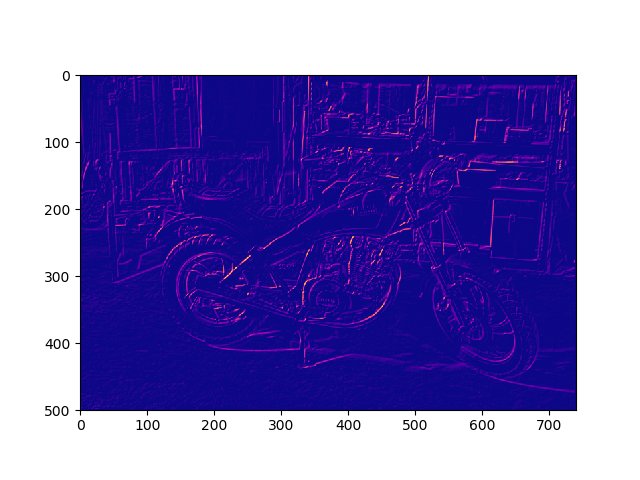

<IPython.core.display.Javascript object>


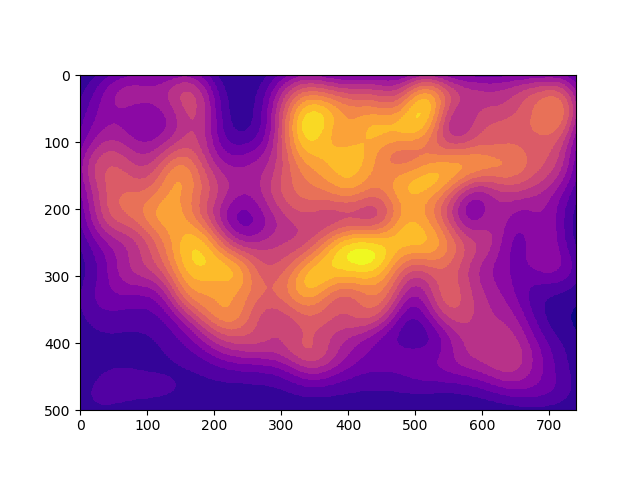

In [18]:
idx = 1
blur_step = 2

imgshow(gradient_orientations[idx], cmap=plt.cm.plasma)
imgshow(coms[blur_step][idx], cmap=plt.cm.plasma)